In [ ]:
import pickle as pk
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from helper_utils.utils import *
from evaluation.metrics import *

In [ ]:
# Load everything

data_directory = "processed_data"
data_filename_base = "X_top300_201801_201912_30_m_final"
data_filename_ext = ".npz"
data_filename = data_filename_base+data_filename_ext

model_store_directory = "stored_models"
run_info_store_directory = "stored_models"

PLOTS_DIRECTORY = "plots"
DATASET_NAME = "bike-share"
MODEL_NAMES = ["LinearRegressor", "FNN_withreg", "FCLSTM", "STGCN_fixedA", 
               "STGCN_adaptiveA", "STGCN_timeadaptiveA",  "STGCN_timeadditiveA",
               "GWN_adaptive", "GWN_timeadaptive", "GWN_timeadditive"]

run_info = {}

for model_name in MODEL_NAMES:

    run_info_store_filename = "_".join([model_name, "run_info"]) + ".pk"
    run_info_store_filepath = os.path.join(run_info_store_directory, run_info_store_filename)
    run_info[model_name] = (pk.load(open(run_info_store_filepath, "rb")))
    
# history_dict = run_info["history"]
# preds = run_info["predictions"]


In [ ]:
data = {}
with np.load(os.path.join(data_directory, data_filename)) as npz_loader:
    for key in npz_loader.files:
        print("{}: {}".format(key, npz_loader[key].shape))
        data[key] = npz_loader[key]

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]

# Input and output dims
input_shape = tuple(list(X_train.shape)[1:])
output_shape = tuple(list(X_train.shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

num_nodes, num_steps, input_features = input_shape
_, _, output_features = output_shape

X_train: (21012, 300, 10, 4)
y_train: (21012, 300, 10, 2)
X_val: (7004, 300, 10, 4)
y_val: (7004, 300, 10, 2)
X_test: (7005, 300, 10, 4)
y_test: (7005, 300, 10, 2)


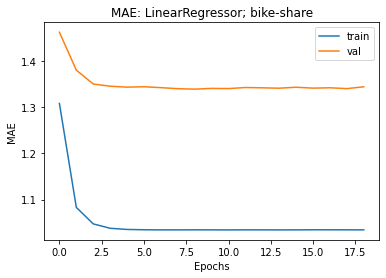

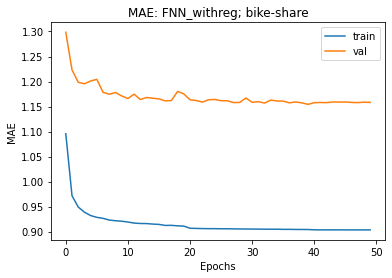

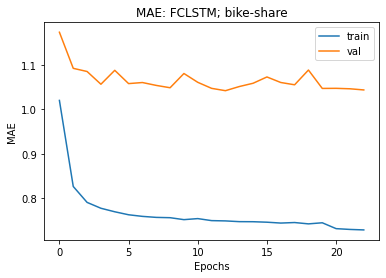

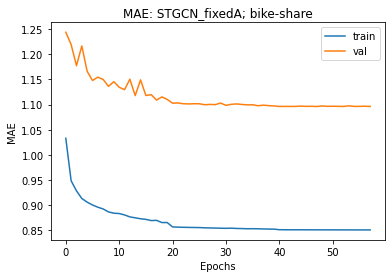

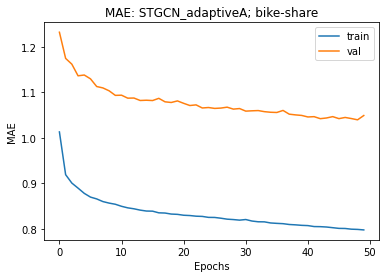

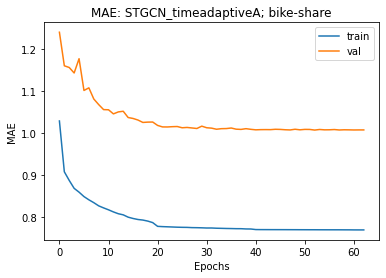

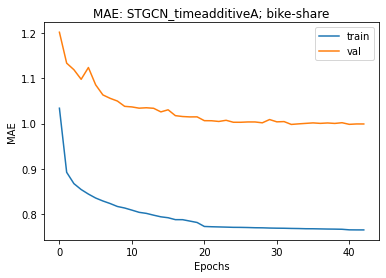

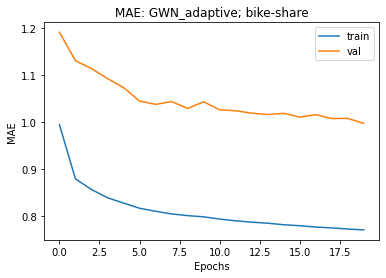

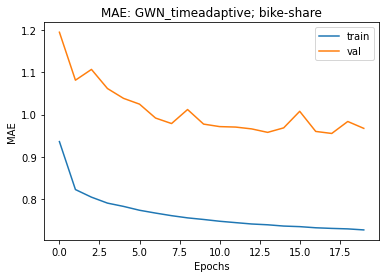

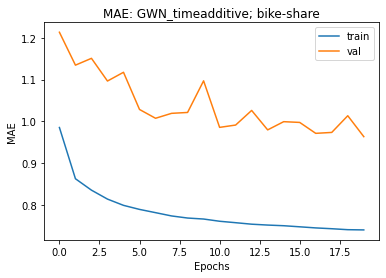

In [ ]:
for MODEL_NAME in MODEL_NAMES:
    plt.figure()
    plt.title("MAE: "+MODEL_NAME+'; '+DATASET_NAME)
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.plot(run_info[MODEL_NAME]['history']['loss'],label='train')
    plt.plot(run_info[MODEL_NAME]['history']['val_loss'],label='val')
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIRECTORY,'loss_'+MODEL_NAME+'_'+DATASET_NAME+'.png'))

In [ ]:
loss_funcs = {'MAE':mae_losses,
              'MSE':mse_losses,
              'SMAPE': smape_losses}
              
loss_axes = (0,1,3)
all_losses = {}

for loss in loss_funcs:
    all_losses[loss] = {}
    for i,MODEL_NAME in enumerate(MODEL_NAMES):
        losses = loss_funcs[loss](run_info[MODEL_NAME]['predictions'],y_test,axes=loss_axes)
        all_losses[loss][MODEL_NAME] = losses

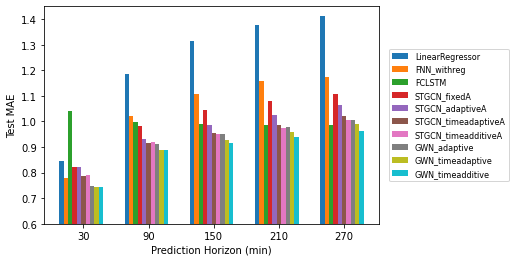

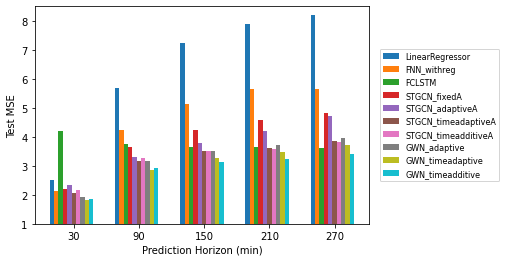

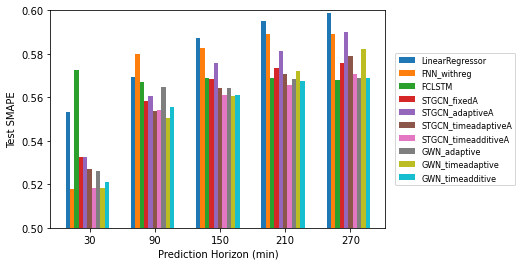

In [ ]:
window_length = 10
window_size = 30
window_unit = 'min'
bar_width = 4
horizons = [0,2,4,6,8]
bar_locations = lambda i, MODEL_NAMES : (np.arange(1,1+window_length)*window_size+bar_width*(i-len(MODEL_NAMES)//2))[horizons]
ticks = [(i+1)*window_size for i in horizons]

ylims = {'MAE': (0.6,1.45),
         'MSE': (1,8.5),
         'SMAPE': (0.5,0.6)}

for loss in loss_funcs:

    plt.figure()
    plt.xticks(ticks, ticks)
    
    for i,MODEL_NAME in enumerate(MODEL_NAMES):
        losses = all_losses[loss][MODEL_NAME]
        plt.bar(bar_locations(i,MODEL_NAMES),losses[horizons],width=bar_width,label=MODEL_NAME)

    plt.ylim(ylims[loss])
    plt.xlabel(f"Prediction Horizon ({window_unit})")
    plt.ylabel('Test ' + loss)
    plt.legend(loc='center right',prop={'size': 8}, bbox_to_anchor=(1.4, 0.5))
    plt.savefig(os.path.join(PLOTS_DIRECTORY,loss+'_comparison_'+DATASET_NAME+'.png'),bbox_inches='tight')

In [ ]:
for MODEL_NAME in MODEL_NAMES:
  print(MODEL_NAME)
  for loss in loss_funcs:
    for val in all_losses[loss][MODEL_NAME][[0,3,9]]:
      print('{:0.3f}'.format(val), end=' &')
    print('{:0.3f}'.format(np.mean(all_losses[loss][MODEL_NAME])), end=' &')
  print()

LinearRegressor
0.845 &1.261 &1.427 &1.266 &2.495 &6.598 &8.299 &6.661 &0.553 &0.579 &0.601 &0.584 &
FNN_withreg
0.777 &1.069 &1.176 &1.075 &2.128 &4.717 &5.658 &4.782 &0.518 &0.581 &0.594 &0.577 &
FCLSTM
1.042 &0.993 &0.987 &0.997 &4.195 &3.692 &3.635 &3.735 &0.573 &0.568 &0.568 &0.569 &
STGCN_fixedA
0.820 &1.016 &1.118 &1.026 &2.216 &3.983 &4.944 &4.070 &0.533 &0.565 &0.579 &0.565 &
STGCN_adaptiveA
0.821 &0.961 &1.082 &0.983 &2.338 &3.572 &4.884 &3.815 &0.532 &0.570 &0.597 &0.572 &
STGCN_timeadaptiveA
0.787 &0.937 &1.048 &0.951 &2.048 &3.380 &4.082 &3.376 &0.527 &0.560 &0.588 &0.563 &
STGCN_timeadditiveA
0.789 &0.938 &1.032 &0.945 &2.172 &3.431 &4.053 &3.398 &0.518 &0.558 &0.578 &0.559 &
GWN_adaptive
0.746 &0.932 &1.022 &0.937 &1.928 &3.393 &4.130 &3.404 &0.526 &0.566 &0.574 &0.562 &
GWN_timeadaptive
0.745 &0.908 &1.017 &0.922 &1.836 &3.063 &3.897 &3.165 &0.518 &0.553 &0.598 &0.562 &
GWN_timeadditive
0.744 &0.903 &0.986 &0.909 &1.870 &3.038 &3.599 &3.038 &0.521 &0.559 &0.579 &0.560 &

In [ ]:
loss_axes = (0,2,3)
station_losses = {}

for loss in loss_funcs:
    station_losses[loss] = {}
    for i,MODEL_NAME in enumerate(MODEL_NAMES):
        losses = loss_funcs[loss](run_info[MODEL_NAME]['predictions'],y_test,axes=loss_axes)
        station_losses[loss][MODEL_NAME] = losses


In [ ]:
for MODEL_NAME in MODEL_NAMES:
  print(MODEL_NAME)
  for loss in loss_funcs:
    print('{:0.3f}'.format(np.mean(station_losses[loss][MODEL_NAME][:20])), end=' &')
    print('{:0.3f}'.format(np.mean(station_losses[loss][MODEL_NAME][-20:])), end=' &')
  print()

LinearRegressor
2.860 &0.549 &29.096 &0.714 &0.528 &0.688 &
FNN_withreg
2.280 &0.471 &20.046 &0.641 &0.490 &0.702 &
FCLSTM
1.989 &0.424 &13.039 &0.577 &0.456 &0.721 &
STGCN_fixedA
2.065 &0.476 &16.178 &0.631 &0.469 &0.701 &
STGCN_adaptiveA
1.995 &0.442 &14.735 &0.618 &0.464 &0.728 &
STGCN_timeadaptiveA
1.844 &0.432 &11.763 &0.586 &0.441 &0.718 &
STGCN_timeadditiveA
1.863 &0.421 &12.122 &0.568 &0.440 &0.715 &
GWN_adaptive
1.827 &0.424 &12.390 &0.548 &0.444 &0.713 &
GWN_timeadaptive
1.768 &0.414 &10.736 &0.561 &0.438 &0.724 &
GWN_timeadditive
1.727 &0.415 &10.235 &0.543 &0.436 &0.714 &


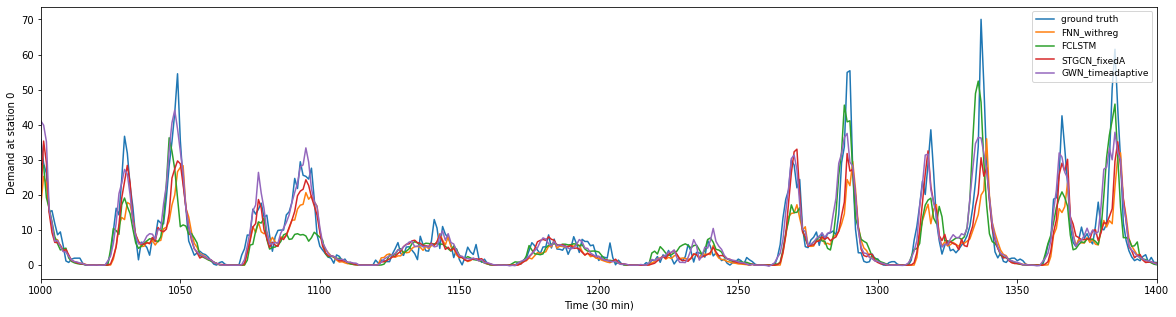

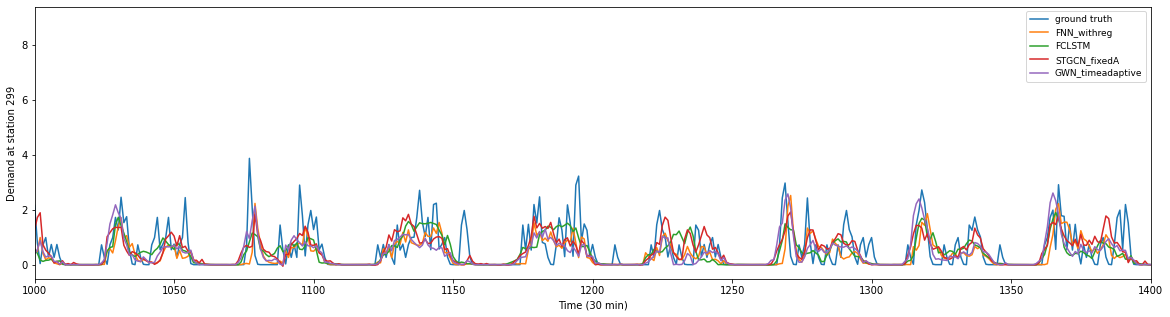

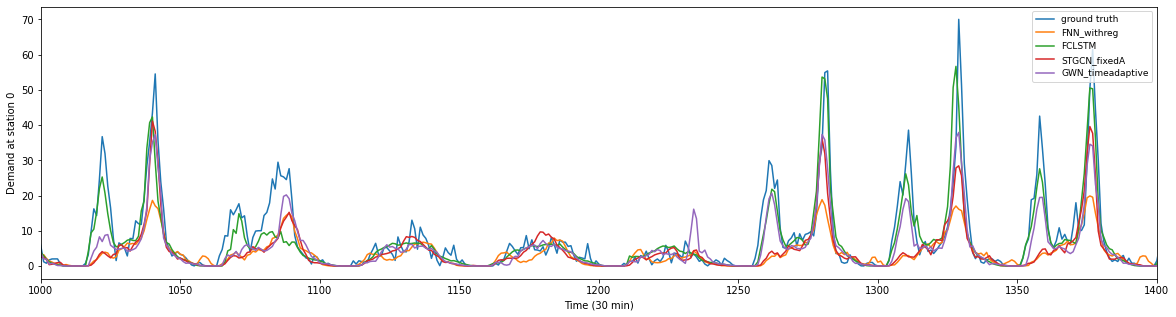

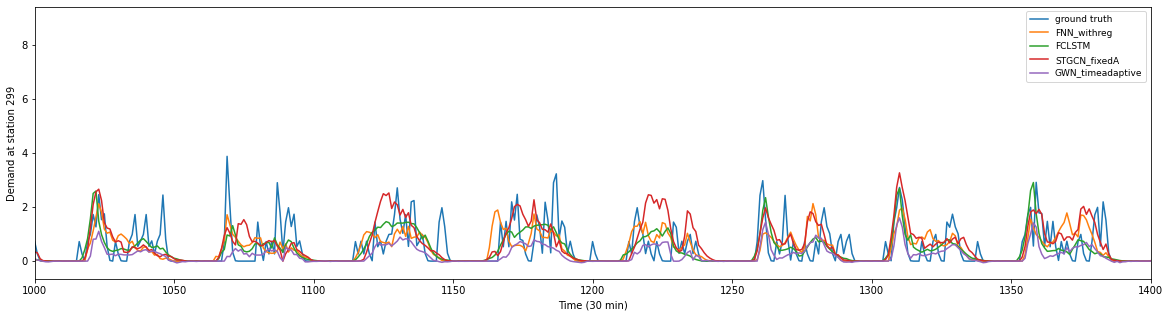

In [ ]:
stations = [0,299]
horizons = [1,9]
feature = 0
feature_names = {0: 'Demand', 1: 'Supply'}
xlim = (1000, 1400)

save = True

MODELS_TO_PLOT = ['FNN_withreg', 'FCLSTM', 'STGCN_fixedA', 'GWN_timeadaptive']


for horizon in horizons:
    
    horizon_ground_truth = seq_from_windows(y_test, horizon=horizon)
    
    for station in stations:
        
        plt.figure(figsize=(20,5))
        plt.xlim(xlim)
        plt.xlabel("Time (30 min)")
        plt.ylabel(f"{feature_names[feature]} at station {station}")
        
        plt.plot(horizon_ground_truth[station,:,feature],label='ground truth')
        
        for MODEL_NAME in MODELS_TO_PLOT:
            
            horizon_predictions = seq_from_windows(run_info[MODEL_NAME]['predictions'], horizon=horizon)
            plt.plot(horizon_predictions[station,:,feature],label=MODEL_NAME)
        
        plt.legend(loc='upper right',prop={'size': 9})
        
        if save:
            plt.savefig(os.path.join(PLOTS_DIRECTORY,'station'+str(station)+'_'+'horizon_'+str(horizon+1)+'_'+DATASET_NAME+'.png'))